# Tree Image Annotation with YOLOv8

In [1]:
from pathlib import Path
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
weights_path = Path("runs/tree_canopy/yolov8n-tree/weights/best.pt")
if not weights_path.exists():
    print(f"Custom weights not found at {weights_path}, falling back to pretrained yolov8n.pt")
    weights_path = Path("yolov8n.pt")
model = YOLO(str(weights_path))
names = model.names if isinstance(model.names, dict) else dict(enumerate(model.names))
print(f"Loaded model from {weights_path}")

Loaded model from runs\tree_canopy\yolov8n-tree\weights\best.pt


In [3]:
def annotate_trees_in_image(image_source, conf=0.25, imgsz=640, show=True, save_path=None):
    """Detect trees in a single image, draw green boxes, and optionally display/save the result."""
    results = model.predict(source=image_source, conf=conf, imgsz=imgsz, save=False, verbose=False)
    if not results:
        raise RuntimeError("Model did not return any predictions; verify the image source.")
    result = results[0]
    if result.orig_img is not None:
        annotated = result.orig_img.copy()
    else:
        if isinstance(image_source, (str, Path)):
            image_path = Path(image_source)
            annotated = cv2.imread(str(image_path))
            if annotated is None:
                raise FileNotFoundError(f"Unable to read image from {image_path}")
        else:
            raise ValueError("Provide a file path or an array-like image for prediction.")
    boxes = result.boxes
    tree_count = 0
    if boxes is not None and len(boxes) > 0:
        xyxy = boxes.xyxy.cpu().numpy().astype(int)
        confidences = boxes.conf.cpu().numpy()
        class_ids = boxes.cls.cpu().numpy().astype(int)
        tree_count = len(xyxy)
        for (x1, y1, x2, y2), cls_id, conf_score in zip(xyxy, class_ids, confidences):
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{names.get(cls_id, 'tree')} {conf_score:.2f}"
            cv2.putText(annotated, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(save_path), annotated)
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        legend_patch = Patch(color="#00FF00", label=f"Trees detected: {tree_count}")
        plt.legend(handles=[legend_patch], loc="lower right", frameon=True)
        plt.axis("off")
        plt.show()
    return annotated, tree_count

In [4]:
def annotate_trees_in_video(source, output_path, conf=0.25, imgsz=640, show=False):
    """Detect trees frame-by-frame from an OpenCV-readable source and save annotated MP4 output."""
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video source {source}")
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 20.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = Path(output_path).expanduser().resolve()
    output_path.parent.mkdir(parents=True, exist_ok=True)
    writer = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        cap.release()
        raise RuntimeError(f"Unable to create video writer at {output_path}")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = model.predict(source=frame, conf=conf, imgsz=imgsz, save=False, verbose=False)
            annotated = frame.copy()
            tree_count = 0
            if results:
                result = results[0]
                boxes = result.boxes
                if boxes is not None and len(boxes) > 0:
                    xyxy = boxes.xyxy.cpu().numpy().astype(int)
                    confidences = boxes.conf.cpu().numpy()
                    class_ids = boxes.cls.cpu().numpy().astype(int)
                    tree_count = len(xyxy)
                    for (x1, y1, x2, y2), cls_id, conf_score in zip(xyxy, class_ids, confidences):
                        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        label = f"{names.get(cls_id, 'tree')} {conf_score:.2f}"
                        cv2.putText(annotated, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(annotated, f"Trees: {tree_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
            writer.write(annotated)
            if show:
                cv2.imshow("Tree Counter", annotated)
                key = cv2.waitKey(1) & 0xFF
                if key in (ord('q'), 27):
                    break
        if show:
            cv2.destroyAllWindows()
    finally:
        cap.release()
        writer.release()
    return str(output_path)

# Usage
- Run Cells 1-3 to load dependencies and the trained model weights.
- `annotate_trees_in_image("/path/to/image.jpg")` draws boxes and returns the annotated array and count.
- `annotate_trees_in_video("/path/to/video.mp4", "./annotated.mp4")` processes each frame, overlays the count, and saves an MP4.
- Adjust `conf` or `imgsz` as needed for your imagery.
- Pass `show=True` to preview video frames in a window (press `q`/`Esc` to quit early).

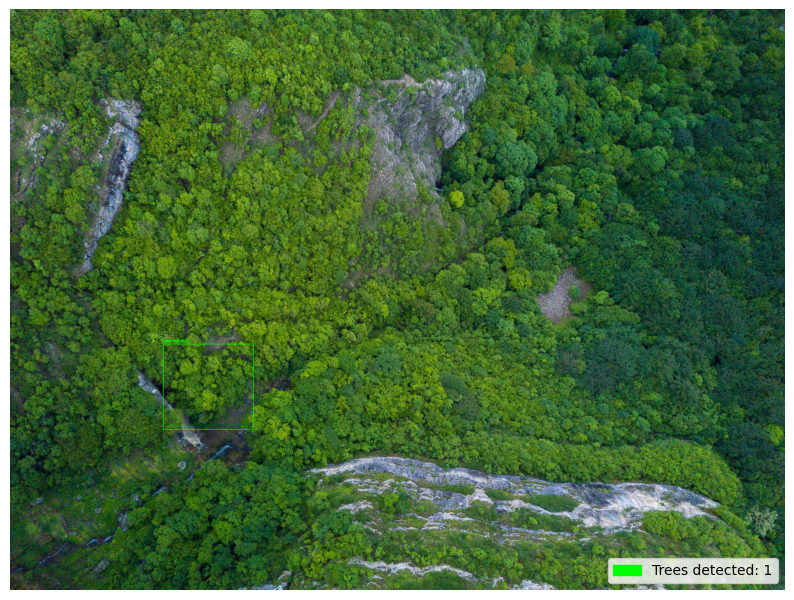

Trees detected: 1


In [7]:
# Example: annotate a single image
annotated_image, tree_total = annotate_trees_in_image("./jungleShot.jpg", conf=0.25, imgsz=640, save_path="./annotatedJungleShot.jpg")
print(f"Trees detected: {tree_total}")



In [6]:
# Example: annotate a video and save as MP4
output_video_path = annotate_trees_in_video("./test.mp4", "./annotatedTestVideo.mp4", conf=0.25, imgsz=640, show=False)
print(f"Annotated video saved to: {output_video_path}")

Annotated video saved to: D:\TreeSense\annotatedTestVideo.mp4
